In [72]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay
from scipy import stats
import pandas as pd
import collections
import yaml
import copy
from astropy.stats import sigma_clip, sigma_clipped_stats
from matplotlib.gridspec import GridSpec

from tabulate import tabulate
import warnings
warnings.filterwarnings('error')

# Functions

In [50]:
## Create dataframe with ptc values from dict

def create_df_PTC(dictname, list_detectors):
    columns = ['Detector_ID','Detector_Num', 'Vendor', 'Amplifier','Gain', 'Read_Noise', 'A00', 'TurnOff']
    df_new = pd.DataFrame(columns = columns)
    #amp_names = dictname[det_id_to_name[list_detectors[0]]].keys()

    for i in list_detectors:
        k=det_id_to_name[i]
        raft, sensor = k.split("_")
        vendor, det_num = getDetector(raft, sensor)
        for c in ampNames:
            df_dummy = pd.DataFrame(zip([k], [det_num], [vendor], [c], [dictname[k][c]['gain']], [dictname[k][c]['rd_noise']], [dictname[k][c]['a00']], [dictname[k][c]['turnoff']]), columns = columns)
            df_new = pd.concat([df_new, df_dummy], ignore_index=True)

    df_new["Gain"] = pd.to_numeric(df_new["Gain"])
    df_new["Read_Noise"] = pd.to_numeric(df_new["Read_Noise"])
    df_new["A00"] = pd.to_numeric(df_new["A00"])
    df_new["TurnOff"] = pd.to_numeric(df_new["TurnOff"])

    #df_new = df_new.dropna(subset=['Gain', 'Read_Noise', "A00", "TurnOff"])
    return df_new

## Create dataframe with cpCovariances values from dict

def create_df_cpCov(dictname, list_detectors):
    columns = ['Detector_ID','Detector_Num', 'Vendor', 'Amplifier','Flux', 'Gain', 'Read_Noise']
    df_new = pd.DataFrame(columns = columns)
    #amp_names = dictname[det_id_to_name[list_detectors[0]]].keys()

    for i in list_detectors:
        k=det_id_to_name[i]
        raft, sensor = k.split("_")
        vendor, det_num = getDetector(raft, sensor)
        for c in ampNames:
            len_list = len(dictname[k][c]['flux'])
            df_dummy = pd.DataFrame(zip([k]*len_list, [det_num]*len_list, [vendor]*len_list, [c]*len_list, dictname[k][c]['flux'], dictname[k][c]['gain'], dictname[k][c]['noise']), columns = columns)
            df_new = pd.concat([df_new, df_dummy], ignore_index=True)

    df_new["Gain"] = pd.to_numeric(df_new["Gain"])
    df_new["Read_Noise"] = pd.to_numeric(df_new["Read_Noise"])
    df_new["Flux"] = pd.to_numeric(df_new["Flux"])  

    #df_new = df_new.dropna(subset=['Flux', 'Gain', 'Read_Noise'])
    return df_new

## Function to know the vendor of each CCD
# Function copied from 
# https://github.com/craiglagegit/ScratchStuff/blob/master/reca/PTC_Curve_Pickle_13144M_03Jun22.ipynb 
# made by Professor Craig Lage

def getDetector(raft, sensor):
    # Subroutine to find vendor and detector number given raft and sensor                                                                                                                                                           
    startingCol = [1,0,0,0,1] # First raft column in each row                                                                                                                                                                       
    rows = [0,3,8,13,18] # Starting raft sequence number of each row                                                                                                                                                                
    if raft in ['R11','R12','R13','R14','R21','R22','R23','R24','R30',\
                'R31','R32','R33','R34']:
        vendor = 'E2V'
    else:
        vendor = 'ITL'
    raftRow = int(list(raft)[1])
    raftCol = int(list(raft)[2])
    sensorRow = int(list(sensor)[1])
    sensorCol = int(list(sensor)[2])
    detectorNum = (rows[raftRow] + (raftCol - startingCol[raftRow])) * 9
    detectorNum += 3 * sensorRow + sensorCol
    return vendor, detectorNum


## function to create dictionary with cpCovariances values
def create_dict_cpCovariances(list_detector, dict_to_write, butler_used):    
    for detector in list_detector:
        for exp in exposure_first:
            cp = butler_used.get("cpCovariances", instrument="LSSTCam", detector=detector, exposure= exp)
            if cp is None:
                print (f"Skipping {exp} {det_id_to_name[i]} because cpCovs is None")
                continue
            for ampName in ampNames:

                dict_to_write[det_id_to_name[detector]][ampName]['noise'].append(cp.noise[ampName])
                dict_to_write[det_id_to_name[detector]][ampName]['gain'].append(cp.gain[ampName])
                dict_to_write[det_id_to_name[detector]][ampName]['flux'].append(cp.rawMeans[ampName][0])
                
                
def create_dict_PTC(list_detector, dic_to_write, butler_used):
    for detector in list_detector:
        ptc = butler_used.get("ptc", instrument="LSSTCam", detector=detector)
        for ampName in ampNames:

            dic_to_write[det_id_to_name[detector]][ampName]["rd_noise"] = ptc.noise[ampName]
            dic_to_write[det_id_to_name[detector]][ampName]["gain"] = ptc.gain[ampName]
            dic_to_write[det_id_to_name[detector]][ampName]["a00"] = ptc.ptcFitPars[ampName][0]
            dic_to_write[det_id_to_name[detector]][ampName]["turnoff"] = ptc.ptcTurnoff[ampName]
            
            
            
## For plots
color_list = cm.get_cmap('plasma', 16) ##Color for amplifier
shapes_list = [".", '+',"o", "v", "x", 's', '*', 'd', '|', '>', '1', 'p','<', '2', '^', '4']


## Function to plot the relative percentage error between the gain and to calculate m, b and r
## (slope, intercept and correlation coefficient)
def plot_relative_error_gain(fig, df_PTC, df_cpCov, CCD, list_dict_mbr, where_save = ''):
    """
    fig: pass the canvas
    df_PTC: dataframe with values from PTC with columns for detector and amplifier
    df_cpCov: dataframe with values from cpCovariances with columns for detector and amplifier
    CCD: number of detector
    list_dict_mbr: List with names of dictionaries for m, b and r
    where_save: By default ''. If the place to save is '', then don't save, only show the figure. Otherwise, 
    give the folder in which you want to save figures. 
    """
    
    ##Plots
    #fig = plt.figure(figsize=(15,6))
    axes = fig.add_axes([0.1,0.1,0.4,0.8]) # eje principal
    axes2 = fig.add_axes([0.15,0.5,0.15,0.25]) # eje interior
    axes3 = fig.add_axes([0.6,0.1,0.3,0.8]) # eje principal
    fig.suptitle(f'Detector {CCD}, {det_id_to_name[CCD]}, {df_PTC[df_PTC.Detector_Num == CCD].Vendor.values[0]}: Relative percentage error in gain and Read-out noise', fontsize=18)
        
    amplifier = df_PTC.Amplifier[:16]
    for i in range(16):

        ptc_values = df_PTC[(df_PTC.Detector_Num == CCD) & (df_PTC.Amplifier == amplifier[i])]
        cp_values = df_cpCov[(df_cpCov.Detector_Num == CCD) & (df_cpCov.Amplifier == amplifier[i])]
        non_saturated = cp_values[cp_values['Flux'] < ptc_values.TurnOff.values[0]]
        
        if ptc_values['Gain'].values == 0:
            print(f'\nPTC gain is equal to zero for detector {CCD} and amplifier {amplifier[i]}')
        else:
            ##Calculate percentage relative error between gain from PTC and cpCovariancces
            relative = abs(non_saturated['Gain'] - ptc_values['Gain'].values)/ptc_values['Gain'].values *100
            
        
        ## Linear fit in low flux regime
        ##Select the region of low flux regime (5000 and 10000 ADU)
        linear_flux = non_saturated[(non_saturated.Flux > 5000) & (non_saturated.Flux < 10000)]
        
        ##If some amplifier doesn't have values in flux in this region, omit it 
        if linear_flux.size == 0:
            print(f"There's no flux between 5000 and 10000 ADU for detector {CCD} and amplifier {amplifier[i]}")
            #############This dictionaries already exist############
            #all_rafts_m[det_id_to_name[CCD[0]]][amplifier[i]] = float(-1)
            #all_rafts_r[det_id_to_name[CCD[0]]][amplifier[i]] = float(-1)
            #######################################################
        else:
            ##Make linear fit in low flux regime
            slope, intercept, r, p, se = stats.linregress(linear_flux['Flux'], relative[linear_flux.index])
            poly1d_fn = np.poly1d([slope, intercept])
            x = np.linspace(5000,10000, 1000)
            
            ############This dictionaries already exist############
            list_dict_mbr[0][det_id_to_name[CCD]][amplifier[i]] = float(slope)
            list_dict_mbr[1][det_id_to_name[CCD]][amplifier[i]] = float(intercept)
            list_dict_mbr[2][det_id_to_name[CCD]][amplifier[i]] = float(r)
            #######################################################
            
            ##Then plot the relative error distribution by the amplifier and the read-out noise
            axes.scatter(non_saturated['Flux'], relative, color = color_list(i), s=10, marker = shapes_list[i])
            axes3.scatter(non_saturated['Flux'], non_saturated['Read_Noise'], color = color_list(i),marker = shapes_list[i] , label=f'{amplifier[i]}: PTC gain = {ptc_values["Gain"].values[0]:.4f}')
                
            ##Then plot the distribution between this range by the amplifier and its respective linear fit
            axes2.scatter(non_saturated['Flux'], relative, color = color_list(i), s=10, marker = shapes_list[i],zorder=1)
            axes2.plot(x, poly1d_fn(x), color = color_list(i), zorder=3)

    for i in [axes,axes3]:
        i.tick_params(labelsize=18)
    axes2.tick_params(labelsize=14)
    axes.set_ylim(0,100)
    axes2.set_xlim(5000, 10000)
    axes2.set_ylim(0,15)
    axes.set_xlabel('Flux [ADU]', fontsize=18)
    axes.set_ylabel('Percent [%]', fontsize=18)
    axes3.set_xlabel('Flux [ADU]', fontsize=18)
    axes3.set_ylabel(r'Noise [$e^-$]', fontsize=18)
    axes3.legend(loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=14)
    if where_save == '':
        plt.show()
    else:
        plt.savefig(f'{where_save}/Relative_Error_Gain_Noise_detector{det_id_to_name[CCD]}.png', bbox_inches='tight')
        plt.close(fig)
    
    return


def create_df_mbr(list_detector, list_dict_mbr):

    columns = ['Detector_ID','Detector_Num', 'Vendor', 'Amplifier','Slope', 'Offset', 'Correlation_Coef']
    df_new = pd.DataFrame(columns = columns)

    for i in list_detector:
        k=det_id_to_name[i]
        raft, sensor = k.split("_")
        vendor, det_num = getDetector(raft, sensor)
        for c in ampNames:
            df_dummy = pd.DataFrame(zip([k], [det_num], [vendor], [c], [list_dict_mbr[0][k][c]], [list_dict_mbr[1][k][c]], [list_dict_mbr[2][k][c]]), columns = columns)
            df_new = pd.concat([df_new, df_dummy], ignore_index=True)

    df_new["Slope"] = pd.to_numeric(df_new["Slope"])
    df_new["Offset"] = pd.to_numeric(df_new["Offset"])
    df_new["Correlation_Coef"] = pd.to_numeric(df_new["Correlation_Coef"])  

    #df_new = df_new.dropna(subset=['Slope','Correlation_Coef', "Correlation_Coef"])
    return df_new



def grouping_clipping_stats(df, columns, sigma, iterations):
    """
    This function uses 'sigma_clip' from astropy 
    https://docs.astropy.org/en/stable/api/astropy.stats.sigma_clip.html#:~:text=Perform%20sigma-clipping%20on%20the,deviations%20from%20a%20center%20value.&text=Invalid%20data%20values%20(i.e.,%20NaN,or%20inf)%20are%20automatically%20clipped.
    ''The data will be iterated over, each time rejecting values that are less or more than a 
    specified number of standard deviations from a center value.''
    

    df: dataframe on which you want to perform the sigma clipping and calculate the statistics (mean, std)
    columns: list of columns names to perform sigma clipping 
    sigma: times of estandar deviation from the median (sigma clip)
    iterations: number of iterations to perform the rejection (sigma clip)
    
    returns: 
        -two dictionaries:
            1. dataframes with clipping applied, keys: E2V, ITL, All
            2. dataframes with statistics (mean and standar deviation for clipping dataframes),
            keys: E2V, ITL, All
    """
    ## Dropping nan values
    df_dropna = df.dropna(subset=columns)
    
    ## Grouping m, b and r data by vendor
    by_vendor = df_dropna.groupby('Vendor')[columns]
    df_E2V = by_vendor.get_group('E2V')
    df_ITL = by_vendor.get_group('ITL')
    
    ## Performing sigma-clipping by the vendor
    E2V_clip = df_E2V.agg(lambda x: sigma_clip(x, sigma=sigma, maxiters=iterations))
    ITL_clip = df_ITL.agg(lambda x: sigma_clip(x, sigma=sigma, maxiters=iterations))
    all_clip = df_dropna[columns].agg(lambda x: sigma_clip(x, sigma=sigma, maxiters=iterations))
    clipping_group = {'E2V': E2V_clip, 'ITL': ITL_clip, 'All':all_clip}
    
    ## Stats by vendor
    
    E2V_stat = df_E2V.agg(lambda x: sigma_clipped_stats(x, sigma=sigma, maxiters=iterations))
    ITL_stat = df_ITL.agg(lambda x: sigma_clipped_stats(x, sigma=sigma, maxiters=iterations))
    all_stat = df_dropna[columns].agg(lambda x: sigma_clipped_stats(x, sigma=sigma, maxiters=iterations))
    
    #E2V_stat = E2V_clip.agg(["mean", "std"])
    #ITL_stat = ITL_clip.agg(["mean", "std"])
    #all_stat = all_clip.agg(["mean", "std"])
    stats_group = {'E2V':E2V_stat, 'ITL':ITL_stat, 'All':all_stat}
    
    return clipping_group, stats_group


def histograms_by_vendor(df_clip_vendor1, df_clip_vendor2, parameter, df_stats_vendor1, df_stats_vendor2, legends, xlabel, colors, precision, ax = ''):
    """
    df_clip_vendor1: dataframe which has data for vendor 1
    df_clip_vendor2: dataframe which has data for vendor 2
    parameter: column to plot (gain, read-out noise...)
    df_stats_vendor1: dataframe with mean and standard deviation for vendor 1. This accepts a dataframe obtained through groupby
    df_stats_vendor2: dataframe with mean and standard deviation for vendor 2
    legends: list with the labels for each vendor
    xlabel: the label for x label
    colors: list of two colors
    precision: precision and format to print mean and standard deviation, e.g. '.2f'
    
    return: 
        -legend 
    """
    
    alpha = 0.3
    if ax == '':
        fig, ax = plt.subplots()
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    sns.histplot(data= df_clip_vendor1, x= parameter, ax=ax, element="step", discrete=False, log_scale=[False, True], color = colors[0], label=legends[0], alpha=alpha);
    sns.histplot(data= df_clip_vendor2, x= parameter, ax=ax, element="step", discrete=False, log_scale=[False, True], color = colors[1], label=legends[1], alpha=alpha);
    
    for vendor_stat, color in zip([df_stats_vendor1, df_stats_vendor2], colors):
        #ax.axvline(vendor_stat[parameter]['mean'], color = color)
        ax.axvline(vendor_stat[parameter][0], color = color)
    
    #leg = ax.legend(title='Vendor', loc='lower center', bbox_to_anchor = (0.5,-0.45), labels=[f"{legends[0]}: Mean = {df_stats_vendor1[parameter]['mean']:{precision}}, σ = {df_stats_vendor1[parameter]['std']:{precision}}",f"{legends[1]}: Mean = {df_stats_vendor2[parameter]['mean']:{precision}}, σ = {df_stats_vendor2[parameter]['std']:{precision}}"])
    leg = ax.legend(title='Vendor', loc='lower center', bbox_to_anchor = (0.5,-0.55), labels=[f"{legends[0]}: Mean = {df_stats_vendor1[parameter][0]:{precision}}, σ = {df_stats_vendor1[parameter][2]:{precision}}",f"{legends[1]}: Mean = {df_stats_vendor2[parameter][0]:{precision}}, σ = {df_stats_vendor2[parameter][2]:{precision}}"], fontsize = 14)
    ax.set_xlabel(xlabel, fontsize = 18)
    ax.set_ylabel('Count', fontsize = 18)
    ax.tick_params(labelsize=14)
    return leg

# Dictionary structure

In [3]:
ampNames = ['C00', 'C01', 'C02','C03','C04','C05','C06', 'C07', 
           'C10', 'C11', 'C12','C13','C14','C15','C16', 'C17']

##Structure for a dictionary with a single parameter
value = {ampName: '' for ampName in ampNames}
##Structure for data from cpCovariances object
cpCov= {ampName: {"flux": [], "gain": [], "noise": []} for ampName in ampNames}
##Structure for data from PTC object
ptc = {ampName: {"gain": '', "rd_noise": '', "a00": '', "turnoff": ''} for ampName in ampNames}


# Loading collection

In [4]:
#genCollection = "u/lgiraldo/bps_ALLCCD_20220701"      ##Old code
genCollection = "u/lgiraldo/bps_ALLCCD_v2_20220804"  ##New code
butler = dB.Butler("/repo/main/", collections=genCollection)

# CCD identifiers

In [5]:
camera = butler.get("camera", instrument="LSSTCam")

det_name_to_id = {}  ##From name to number
det_id_to_name = {}  ##From number to name
det_name_array = []  ##List with names

for det in camera:
    #print(det.getName(), det.getId())
    detName, detId = det.getName(), det.getId()
    if detId < 189:
        det_name_to_id[detName] = detId
        det_id_to_name[detId] = detName
        det_name_array.append(detName)

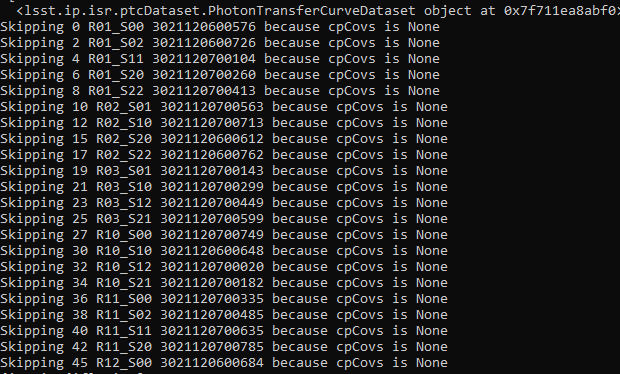

# Generating the list with the first value from pair of exposures

In [6]:
CCD = 72
ccd_data= butler.get("ptc", instrument="LSSTCam", detector=CCD)

# Exposure pairs list
exposure_pairs = np.array(sorted(ccd_data.inputExpIdPairs['C00']))
exposure_first = exposure_pairs[:,0][:,0]

## Saving exposures 

In [7]:
np.save('./Data_files/exposure_pairs.txt', np.reshape(exposure_pairs, (338, 2)))

In [8]:
cpCovs = butler.get("cpCovariances", instrument="LSSTCam", detector=0, exposure=exposure_first[0])

In [9]:
exposure_first[0], cpCovs.gain

(3021120600576,
 {'C00': 1.481415182494028,
  'C01': 1.4988703769818197,
  'C02': 1.5158805120476972,
  'C03': 1.4340898831114448,
  'C04': 1.4511134849312517,
  'C05': 1.5743155790568217,
  'C06': 1.4692488315658456,
  'C07': 1.516210491812103,
  'C10': 1.7310902966763335,
  'C11': 1.7119689179878346,
  'C12': 1.7162355814185344,
  'C13': 1.7151995662224508,
  'C14': 1.6768488479028552,
  'C15': 1.7167728421196955,
  'C16': 1.6670211229366108,
  'C17': 1.5403268613405403})

# Loading PTC data 

In [10]:
#with open('./Data_files/PTC_allvalues_dict.yaml', 'r') as file:  ##Old code
with open('./Data_files/PTC_allvalues_dict_2022AUG05.yaml', 'r') as file:  ##New code
    PTC_data_dict = yaml.safe_load(file)
    
PTC_data = create_df_PTC(PTC_data_dict, np.arange(189))

In [74]:
PTC_data.to_csv('df_PTC_newcode.csv', index = False)

In [11]:
print(len(PTC_data), PTC_data.A00.min(), PTC_data.TurnOff.min())
PTC_data.head()

3024 -0.7081045920936081 0.0


,Detector_ID,Detector_Num,Vendor,Amplifier,Gain,Read_Noise,A00,TurnOff
0,R01_S00,0,ITL,C00,1.602594,6.035249,-0.000002,74918.561200
1,R01_S00,0,ITL,C01,1.593339,5.937206,-0.000002,73830.511171
2,R01_S00,0,ITL,C02,1.590703,6.018622,-0.000002,72504.390664
3,R01_S00,0,ITL,C03,1.589087,6.080679,-0.000002,72801.819624
4,R01_S00,0,ITL,C04,1.583272,6.206142,-0.000002,73461.156208


Existen valores nulos solamente para los valores de A00 de los detectores 72 y 117. Las demás columnas están con valores de cero.

In [12]:
PTC_data[PTC_data.A00.isnull()]

,Detector_ID,Detector_Num,Vendor,Amplifier,Gain,Read_Noise,A00,TurnOff
1167,R20_S00,72,ITL,C17,0.0,0.0,NaN,0.0
1880,R30_S00,117,E2V,C10,0.0,0.0,NaN,0.0


El valor usual de la ganancia se encuentra alrededor de 3. Solo el detector 22 en su amplificador C00 tiene un valor superior a este (muy superior). 

In [13]:
PTC_data[PTC_data.Gain > 2]

,Detector_ID,Detector_Num,Vendor,Amplifier,Gain,Read_Noise,A00,TurnOff
352,R03_S11,22,ITL,C00,15.21174,44.008695,-0.708105,223.072261


## Detector with low PTC-turnoff (< 40000 ADU)

In [14]:
low_turnoff = PTC_data[PTC_data.TurnOff <= 40000]
low_turnoff

,Detector_ID,Detector_Num,Vendor,Amplifier,Gain,Read_Noise,A00,TurnOff
255,R02_S20,15,ITL,C17,1.671910,5.819732,-0.000002,30567.376706
352,R03_S11,22,ITL,C00,15.211740,44.008695,-0.708105,223.072261
504,R10_S11,31,ITL,C10,1.634126,4.131770,-0.000004,32842.445964
1167,R20_S00,72,ITL,C17,0.000000,0.000000,NaN,0.000000
1168,R20_S01,73,ITL,C00,1.608303,6.452793,-0.000003,35507.397317
1232,R20_S12,77,ITL,C00,1.592316,4.704270,-0.000008,26827.109317
1880,R30_S00,117,E2V,C10,0.000000,0.000000,NaN,0.000000
2702,R41_S20,168,ITL,C16,1.610736,6.078176,-0.000002,37863.166694
2703,R41_S20,168,ITL,C17,1.592275,9.572562,-0.000003,26119.952505
2706,R41_S21,169,ITL,C02,1.080946,62.877515,-0.000045,16237.884413


In [16]:
#print(tabulate(low_turnoff, low_turnoff.columns, tablefmt="latex"))

## PTC histograms

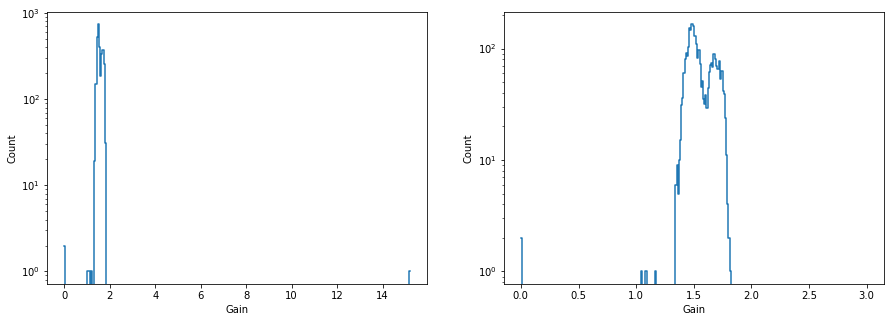

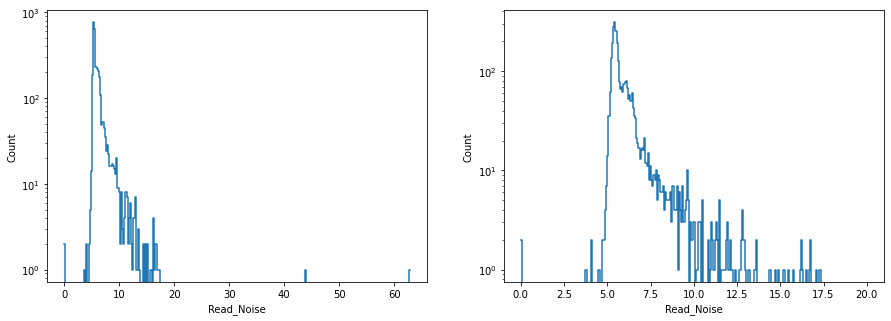

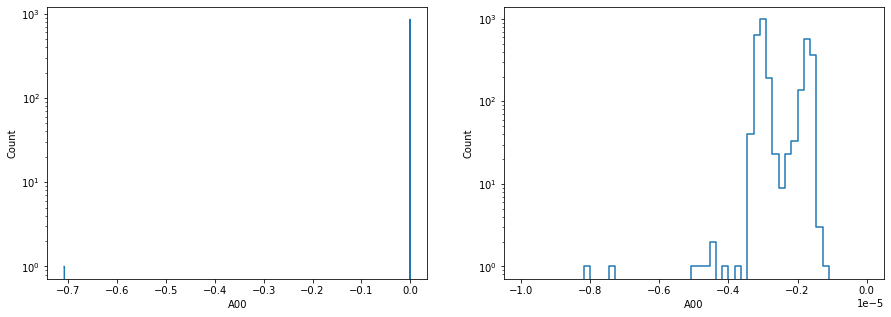

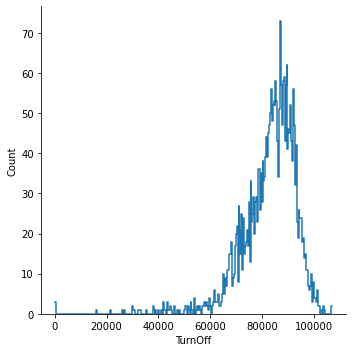

In [17]:
fig, axes = plt.subplots(1,2, figsize= (15,5))
sns.histplot(data = PTC_data, x= 'Gain', bins=300, element="step", fill=False, log_scale=[False,True], ax= axes[0]);
sns.histplot(data = PTC_data, x= 'Gain', bins=300, element="step", fill=False, log_scale=[False,True], ax= axes[1], binrange=[0,3]);

fig, axes = plt.subplots(1,2, figsize= (15,5))
sns.histplot(data = PTC_data, x= 'Read_Noise', bins=300, element="step", fill=False, log_scale=[False,True], ax=axes[0]);
sns.histplot(data = PTC_data, x= 'Read_Noise', bins=300, element="step", fill=False, log_scale=[False,True], ax=axes[1], binrange=[0,20]);

fig, axes = plt.subplots(1,2, figsize= (15,5))
sns.histplot(data = PTC_data, x= 'A00',  element="step", fill=False, log_scale=[False,True], ax=axes[0]);
sns.histplot(data = PTC_data, x= 'A00',  element="step", fill=False, log_scale=[False,True], ax=axes[1], binrange=[-1e-5,0]);
#plt.xlim(-0.00005, 0)
sns.displot(data = PTC_data, x= 'TurnOff', bins=300, element="step", fill=False, log_scale=[False,False]);
#plt.xlim(0,3)

## PTC histogram made by SLAC
https://srs.slac.stanford.edu/BOT_EO_Reports/13144/

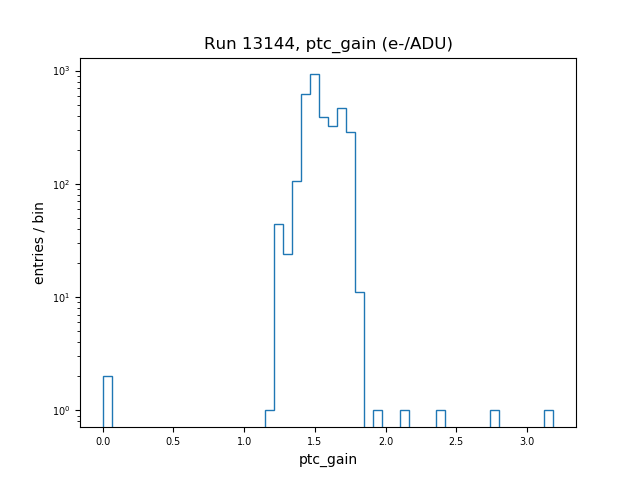

# Loagind cpCovariances

In [18]:
#with open('./Data_files/BOT_gains_from_flats_2022JUL14.yaml', 'r') as file:  ##Old code
with open('./Data_files/BOT_gains_from_flats_2022AUG05.yaml', 'r') as file:  ##New code
    cp_values = yaml.safe_load(file)

In [19]:
cpCov_data = create_df_cpCov(cp_values, np.arange(189))
cpCov_data.head()

,Detector_ID,Detector_Num,Vendor,Amplifier,Flux,Gain,Read_Noise
0,R01_S00,0,ITL,C00,243.170201,1.561976,3.634567
1,R01_S00,0,ITL,C00,54.638722,1.480600,3.634567
2,R01_S00,0,ITL,C00,409.804666,1.590254,3.634567
3,R01_S00,0,ITL,C00,23.023668,1.389505,3.634567
4,R01_S00,0,ITL,C00,128.393437,1.605472,3.634567


In [75]:
cpCov_data.to_csv('df_cpCov_newcode.csv', index = False)

Los detectores 72 y 117 contienen valores nulos del flujo (400 puntos nulos) correspondiente a dos amplificadores, C17(detector 72) y C10 (detector 117). La ganancia tiene un valor de cero (det 72) y valores negativos (det 117, incluye cero).

In [20]:
nan_flux = cpCov_data.loc[cpCov_data.Flux.isnull()]
nan_flux.Detector_Num.drop_duplicates()

394094     72
635209    117
Name: Detector_Num, dtype: object

In [21]:
nan_flux[nan_flux.Detector_Num==72].Amplifier.drop_duplicates(), nan_flux[nan_flux.Detector_Num==72].Gain.drop_duplicates()

(394094    C17
 Name: Amplifier, dtype: object,
 394094    0.0
 Name: Gain, dtype: float64)

In [22]:
nan_flux[nan_flux.Detector_Num==117].Amplifier.drop_duplicates(), nan_flux[nan_flux.Detector_Num==117].Gain.drop_duplicates();

In [23]:
negative_cpCov = cpCov_data[cpCov_data.Gain <= 0]
negative_cpCov_det = negative_cpCov.Detector_Num.drop_duplicates()
print(f"El número de ganancias negativas o iguales a cero son {len(negative_cpCov)}. Por detector hay: {len(negative_cpCov[negative_cpCov.Detector_Num == 22])}")
print(f"Los detectores con ganancias negativas son: {negative_cpCov_det.values}")

El número de ganancias negativas o iguales a cero son 913. Por detector hay: 162
Los detectores con ganancias negativas son: [2 17 22 72 79 112 117 118 169 180]


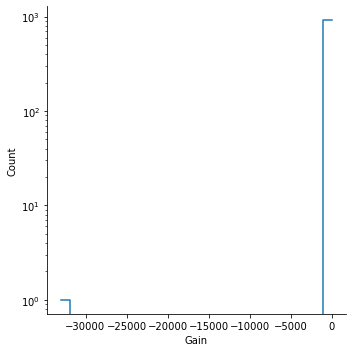

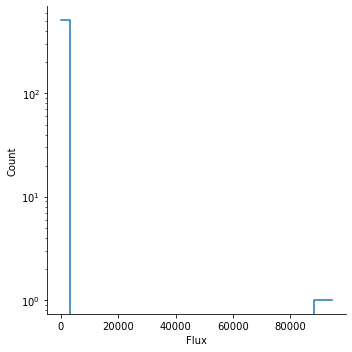

In [24]:
sns.displot(data = negative_cpCov, x='Gain', element="step", bins = 30,  fill=False, log_scale=[False,True]);
sns.displot(data = negative_cpCov, x='Flux', element="step", bins = 30,  fill=False, log_scale=[False,True]);

# Creating the dictionary structure for the values of slope (m) and the Pearson's correlation coefficient (r). For all rafts

In [25]:
all_rafts_m = {detName: copy.deepcopy(value) for detName in det_name_array}
all_rafts_b = {detName: copy.deepcopy(value) for detName in det_name_array}
all_rafts_r = {detName: copy.deepcopy(value) for detName in det_name_array}

## Function to plot the relative percentage error between the gain and to calculate m and r

In [26]:
## Using df constructed from dictionary
for k in range(189):    
    fig = plt.figure(figsize=(15,6))
    plot_relative_error_gain(fig, PTC_data, cpCov_data, k, [all_rafts_m, all_rafts_b, all_rafts_r], where_save = './Image_test')

There's no flux between 5000 and 10000 ADU for detector 22 and amplifier C00

PTC gain is equal to zero for detector 72 and amplifier C17
There's no flux between 5000 and 10000 ADU for detector 72 and amplifier C17

PTC gain is equal to zero for detector 117 and amplifier C10
There's no flux between 5000 and 10000 ADU for detector 117 and amplifier C10


In [26]:
date = '2022AUG05' 
#Dump data in a yaml file
with open(f'./Data_files/Slope_LowFluxRegime_{date}.yaml', 'w') as outfile:
    yaml.dump(all_rafts_m, outfile)
    
with open(f'./Data_files/Offset_LowFluxRegime_{date}.yaml', 'w') as outfile:
    yaml.dump(all_rafts_b, outfile)
    
with open(f'./Data_files/Correlation_coefficient_LowFluxRegime_{date}.yaml', 'w') as outfile:
    yaml.dump(all_rafts_r, outfile)

## Plotting the problematic amplifiers

The amplifier 'C17' from detector 72 has NaN values in the whole flux.

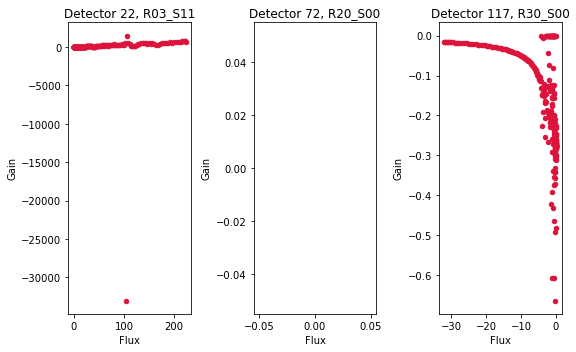

In [27]:
det22 = cpCov_data[(cpCov_data.Detector_Num ==22)&(cpCov_data.Amplifier == 'C00')]
det72 = cpCov_data[(cpCov_data.Detector_Num ==72)&(cpCov_data.Amplifier == 'C17')]
det117 = cpCov_data[(cpCov_data.Detector_Num ==117)&(cpCov_data.Amplifier == 'C10')]

fig, axes = plt.subplots(1,3, figsize=(8,5))
det22.plot.scatter( x= 'Flux', y = 'Gain', ax=axes[0], title= f'Detector 22, {det_id_to_name[22]}', color='crimson')
det72.plot.scatter( x= 'Flux', y = 'Gain', ax=axes[1], title= f'Detector 72, {det_id_to_name[72]}', color='crimson')
det117.plot.scatter( x= 'Flux', y = 'Gain', ax=axes[2], title= f'Detector 117, {det_id_to_name[117]}', color='crimson');
fig.tight_layout()

# Dataframe for m, b y r values

In [28]:
df_slope = create_df_mbr(np.arange(189), [all_rafts_m, all_rafts_b, all_rafts_r])
df_slope.head()

,Detector_ID,Detector_Num,Vendor,Amplifier,Slope,Offset,Correlation_Coef
0,R01_S00,0,ITL,C00,0.000344,-0.282623,0.908204
1,R01_S00,0,ITL,C01,0.000340,-0.077274,0.834165
2,R01_S00,0,ITL,C02,0.000337,-0.083834,0.802959
3,R01_S00,0,ITL,C03,0.000301,0.125313,0.833026
4,R01_S00,0,ITL,C04,0.000267,0.090928,0.776482


In [29]:
df_slope.dtypes

Detector_ID          object
Detector_Num         object
Vendor               object
Amplifier            object
Slope               float64
Offset              float64
Correlation_Coef    float64
dtype: object

In [30]:
df_slope[(df_slope.Detector_Num==72) & (df_slope.Amplifier == 'C17')]

,Detector_ID,Detector_Num,Vendor,Amplifier,Slope,Offset,Correlation_Coef
1167,R20_S00,72,ITL,C17,NaN,NaN,NaN


## Histograms for the rate of change of the relative percentage error for gain (left) and correlation coefficient (right)

In [31]:
##Dictionaries with "df_slope" clipped (g_clip) and its statistics (g_stat) by vendor
nsigma = 3
niter = 3
g_clip, g_stat = grouping_clipping_stats(df_slope, ["Slope", "Correlation_Coef", "Offset"], nsigma, niter)

g_clip['E2V'].head()
g_stat['E2V']

,Slope,Correlation_Coef,Offset
0,0.000462,0.917508,-0.579538
1,0.000462,0.920019,-0.588470
2,0.000037,0.025186,0.428808


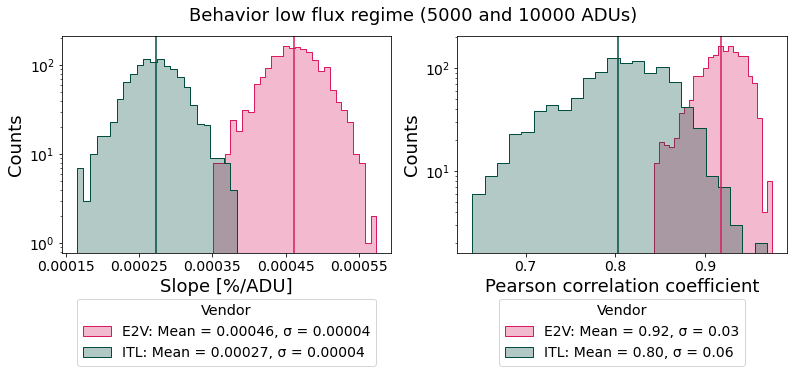

In [49]:
colors_vendor = ['#D81B60', '#004D40']#'#FFC107']

fig, axs = plt.subplots(1,2,figsize=(13,4))
fig.suptitle("Behavior low flux regime (5000 and 10000 ADUs)", fontsize = 18)
histograms_by_vendor(g_clip['E2V'], g_clip['ITL'], 'Slope', g_stat['E2V'], g_stat['ITL'], ['E2V', 'ITL'], 'Slope [%/ADU]', colors_vendor, '.5f', ax=axs[0]);
histograms_by_vendor(g_clip['E2V'], g_clip['ITL'], 'Correlation_Coef', g_stat['E2V'], g_stat['ITL'], ['E2V', 'ITL'], 'Pearson correlation coefficient', colors_vendor, '.2f', ax=axs[1]);
xtick_loc = [0.00015, 0.00025, 0.00035, 0.00045, 0.00055]
axs[0].set_xticks(xtick_loc);

fig.savefig('./FocalPlane_plots/Histogram_slope_corr_new.png', bbox_inches='tight')

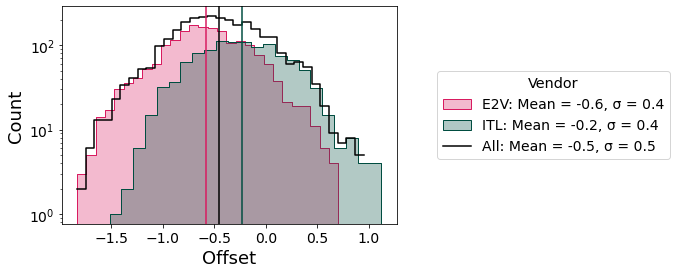

In [55]:
colors_vendor1 = ['#D81B60', '#004D40', 'black']
alpha=0.3
fig, ax = plt.subplots(figsize=(6,4))
plt.rcParams['legend.title_fontsize'] = 'x-large'
sns.histplot(data= g_clip['E2V'], x= 'Offset', element="step",  discrete=False, ax=ax, log_scale=[False, True], color = colors_vendor[0], label='E2V', alpha=alpha);
sns.histplot(data= g_clip['ITL'], x= 'Offset', element="step", discrete=False, ax=ax, log_scale=[False, True], color = colors_vendor[1], label='ITL', alpha=alpha);
sns.histplot(data= g_clip['All'], x= 'Offset', element="step", fill=False, discrete=False, ax=ax, log_scale=[False, True], color = 'black', label='All');



for vendor, color in zip(['E2V', 'ITL', 'All'], colors_vendor1):
    ax.axvline(g_stat[vendor]['Offset'][0], color = color)
ax.tick_params(labelsize=14)
ax.set_xlabel('Offset', fontsize = 18)
ax.set_ylabel('Count', fontsize = 18)

ax.legend(title='Vendor',loc='center left', bbox_to_anchor = (1.1,0.5), labels=[f"E2V: Mean = {g_stat['E2V']['Offset'][0]:.1f}, σ = {g_stat['E2V']['Offset'][2]:.1f}",f"ITL: Mean = {g_stat['ITL']['Offset'][0]:.1f}, σ = {g_stat['ITL']['Offset'][2]:.1f}", f"All: Mean = {g_stat['All']['Offset'][0]:.1f}, σ = {g_stat['All']['Offset'][2]:.1f}"], fontsize = 14);
plt.savefig('./FocalPlane_plots/Histogram_offset_new.png', bbox_inches='tight')

### Outliers
Identify problematic amplifiers

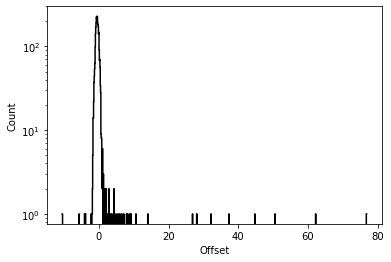

In [57]:
sns.histplot(data= df_slope, x= 'Offset', element="step", fill=False, discrete=False, log_scale=[False, True], color = 'black', label='All');

In [58]:
g_clip_PTC, g_stat_PTC = grouping_clipping_stats(PTC_data, ["Gain", "Read_Noise", "A00", "TurnOff"], 3, 3)

g_clip_PTC['E2V'].head()

,Gain,Read_Noise,A00,TurnOff
576,1.533049,5.441754,-0.000003,85487.426372
577,1.545493,5.603886,-0.000003,82722.239940
578,1.541396,5.575896,-0.000003,83329.817354
579,1.535443,5.723117,-0.000003,83919.390040
580,1.546364,5.784581,-0.000003,84019.562310


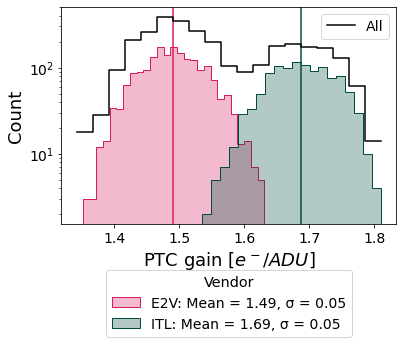

In [71]:
fig, ax = plt.subplots()
leg = histograms_by_vendor(g_clip_PTC['E2V'], g_clip_PTC['ITL'], 'Gain', g_stat_PTC['E2V'], g_stat_PTC['ITL'], ['E2V', 'ITL'], 'PTC gain [$e^-/ADU$]', colors_vendor, '.2f', ax=ax)
as1 = sns.histplot(data= g_clip_PTC['All'], x= 'Gain', element="step", fill=False, discrete=False, ax=ax, log_scale=[False, True], color = 'black', label='All');
ax.add_artist(leg)
h, l = ax.get_legend_handles_labels()
ax.legend(labels = [l[2]], handles = [h[2]], fontsize=14);

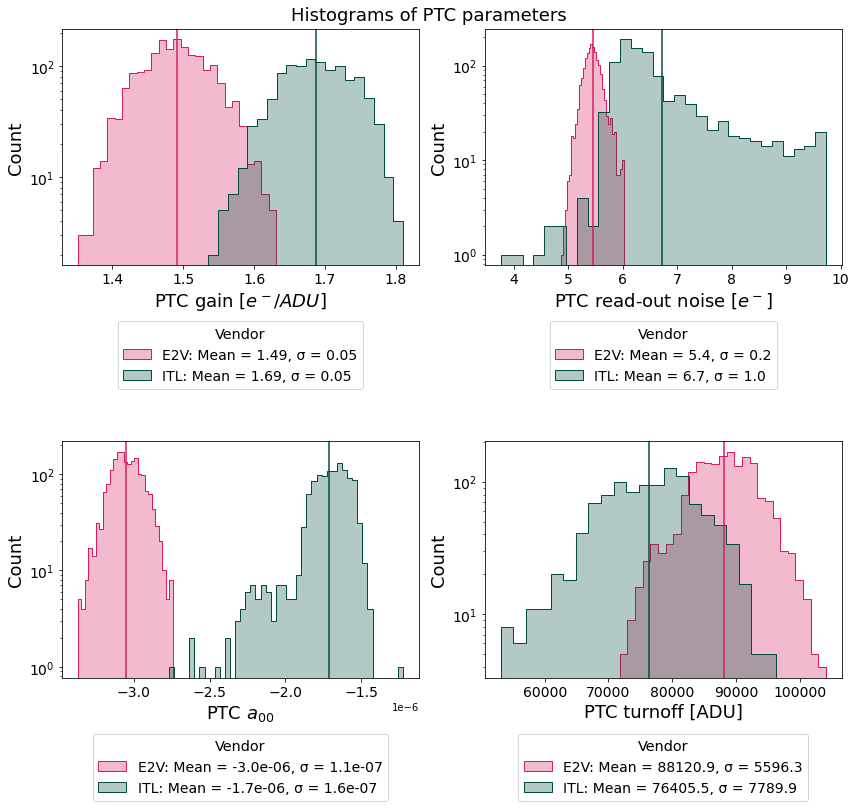

In [62]:
E2V_PTC_clip, ITL_PTC_clip = g_clip_PTC['E2V'], g_clip_PTC['ITL']
E2V_PTC_stat, ITL_PTC_stat = g_stat_PTC['E2V'], g_stat_PTC['ITL']

fig = plt.figure(figsize=(12,12))
gs = GridSpec(4,4)
fig.suptitle('Histograms of PTC parameters', fontsize=18)

############################################################################################
axes = plt.subplot(gs[0:2,:2])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'Gain', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC gain [$e^-/ADU$]', colors_vendor, '.2f', ax=axes)


############################################################################################
ax1 = plt.subplot(gs[0:2,2:4])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'Read_Noise', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC read-out noise [$e^-$]', colors_vendor, '.1f', ax=ax1)


############################################################################################
ax2 = plt.subplot(gs[2:4,:2])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'A00', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], r'PTC $a_{00}$', colors_vendor, '.1e', ax=ax2)

############################################################################################
ax3 = plt.subplot(gs[2:4,2:4])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'TurnOff', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC turnoff [ADU]', colors_vendor, '.1f', ax=ax3)


############################################################################################


fig.tight_layout()
fig.savefig('./FocalPlane_plots/Histograms_PTC.png')

In [79]:
colors_vendor_m = colors_vendor[::-1]
colors_vendor_m

['#004D40', '#D81B60']

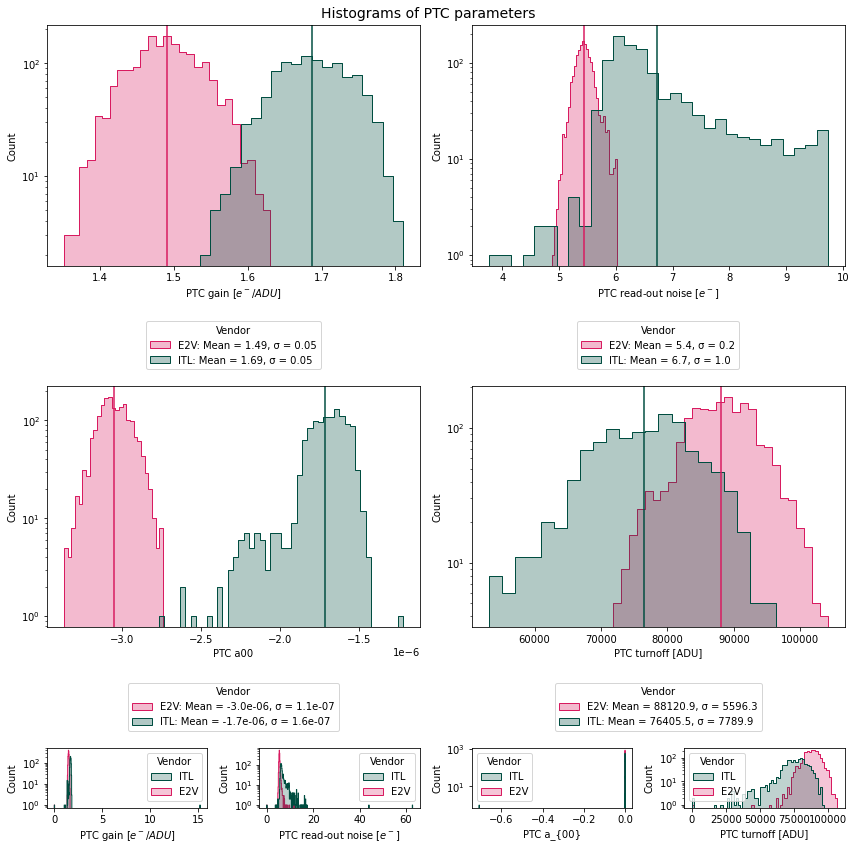

In [83]:
E2V_PTC_clip, ITL_PTC_clip = g_clip_PTC['E2V'], g_clip_PTC['ITL']
E2V_PTC_stat, ITL_PTC_stat = g_stat_PTC['E2V'], g_stat_PTC['ITL']

fig = plt.figure(figsize=(12,12))
gs = GridSpec(5,4)
fig.suptitle('Histograms of PTC parameters', fontsize=14)

############################################################################################
axes = plt.subplot(gs[0:2,:2])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'Gain', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC gain [$e^-/ADU$]', colors_vendor, '.2f', ax=axes)


############################################################################################
ax1 = plt.subplot(gs[0:2,2:4])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'Read_Noise', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC read-out noise [$e^-$]', colors_vendor, '.1f', ax=ax1)


############################################################################################
ax2 = plt.subplot(gs[2:4,:2])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'A00', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC a00', colors_vendor, '.1e', ax=ax2)

############################################################################################
ax3 = plt.subplot(gs[2:4,2:4])
histograms_by_vendor(E2V_PTC_clip, ITL_PTC_clip, 'TurnOff', E2V_PTC_stat, ITL_PTC_stat, ['E2V', 'ITL'], 'PTC turnoff [ADU]', colors_vendor, '.1f', ax=ax3)


############################################################################################
plt.subplot(gs[4,0])
ax4 = sns.histplot(data= PTC_data, x= 'Gain', hue='Vendor', element="step", discrete=False, log_scale=[False, True], palette = colors_vendor_m);
ax4.set_xlabel('PTC gain [$e^-/ADU$]')

plt.subplot(gs[4,1])
ax5 = sns.histplot(data= PTC_data, x= 'Read_Noise', hue='Vendor', element="step", discrete=False,  log_scale=[False, True], palette = colors_vendor_m);
ax5.set_xlabel('PTC read-out noise [$e^-$]')

plt.subplot(gs[4,2])
ax6 = sns.histplot(data= PTC_data, x= 'A00', hue='Vendor', element="step" ,discrete=False,  log_scale=[False, True], palette = colors_vendor_m);
sns.move_legend(ax6, loc='upper left')
ax6.set_xlabel('PTC a_{00}')

plt.subplot(gs[4,3])
ax7 = sns.histplot(data= PTC_data, x= 'TurnOff', hue='Vendor', element="step", discrete=False,  log_scale=[False, True], palette = colors_vendor_m);
sns.move_legend(ax7, loc='upper left')
ax7.set_xlabel('PTC turnoff [ADU]')

fig.tight_layout()
#fig.savefig('./FocalPlane_plots/Histograms_PTC.png', dpi=500)

# Taking into account the linearizers for both CCDs 55 and 74

The linearizers were generated by Jerónimo Calderón in his project supervised by Professor Craig Lage. This linearizer is spline type and has 12 knots. 

In [63]:
genCollection_linearizer = "u/jcalderong/reca/ptc_13144_crosstalktests_L"  #Linearizer
butler_linearizer = dB.Butler("/repo/main/", collections=genCollection_linearizer)

CCD = 139
pctDataset= butler.get("ptc", instrument="LSSTCam", detector=CCD)

# Exposure pairs list
exposure_pairs = np.array(sorted(pctDataset.inputExpIdPairs['C00']))
exposure_first = exposure_pairs[:,0][:,0]

cp_linearizer = butler_linearizer.get("cpCovariances", instrument="LSSTCam", detector=CCD, exposure= exposure_first[0])

## Creating dictionaries

In [64]:
CCDs = [32, 139]

CCD55_74_PTC= {det_id_to_name[det]: copy.deepcopy(ptc) for det in CCDs}
CCD55_74_cpCov = {det_id_to_name[det]: copy.deepcopy(cpCov) for det in CCDs}

In [65]:
create_dict_PTC(CCDs, CCD55_74_PTC, butler_linearizer)

In [66]:
with open('./Data_files/Linearizer_Spline12_PTC_CCD_32_139_20220814.yaml', 'w') as outfile:
    yaml.dump(CCD55_74_PTC, outfile)

In [67]:
create_dict_cpCovariances(CCDs, CCD55_74_cpCov, butler_linearizer)

In [19]:
with open('./Data_files/Linearizer_Spline12_cpCov_CCD_32_139_20220814.yaml', 'w') as outfile:
    yaml.dump(CCD55_74_cpCov, outfile)

## Creating dataframes

In [68]:
df_PTC_Spline12 = create_df_PTC(CCD55_74_PTC, CCDs)
df_PTC_Spline12.head()

,Detector_ID,Detector_Num,Vendor,Amplifier,Gain,Read_Noise,A00,TurnOff
0,R10_S12,32,ITL,C00,1.649012,8.793140,-0.000002,89595.922092
1,R10_S12,32,ITL,C01,1.638996,9.336931,-0.000002,88616.150384
2,R10_S12,32,ITL,C02,1.641314,9.592488,-0.000002,88883.913479
3,R10_S12,32,ITL,C03,1.636528,9.835264,-0.000002,89672.749481
4,R10_S12,32,ITL,C04,1.617491,9.268076,-0.000002,90947.330812


In [69]:
df_cpCov_Spline12 = create_df_cpCov(CCD55_74_cpCov, CCDs)
df_cpCov_Spline12.head()

,Detector_ID,Detector_Num,Vendor,Amplifier,Flux,Gain,Read_Noise
0,R10_S12,32,ITL,C00,50.302302,1.418944,4.932315
1,R10_S12,32,ITL,C00,273.167015,1.616776,4.932315
2,R10_S12,32,ITL,C00,57.848287,1.471736,4.932315
3,R10_S12,32,ITL,C00,464.164963,1.616865,4.932315
4,R10_S12,32,ITL,C00,21.309291,1.003646,4.932315


In [70]:
all_rafts_m = {det_id_to_name[det]: copy.deepcopy(value) for det in CCDs}
all_rafts_b = {det_id_to_name[det]: copy.deepcopy(value) for det in CCDs}
all_rafts_r = {det_id_to_name[det]: copy.deepcopy(value) for det in CCDs}

In [53]:
## Using df constructed from dictionary
for k in CCDs:    
    fig = plt.figure(figsize=(15,6))
    plot_relative_error_gain(fig, df_PTC_Spline12, df_cpCov_Spline12, k, [all_rafts_m, all_rafts_b, all_rafts_r], where_save = 'FocalPlane_plots')

# Outliers in cpCovariances around 20000 ADU

[157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157]


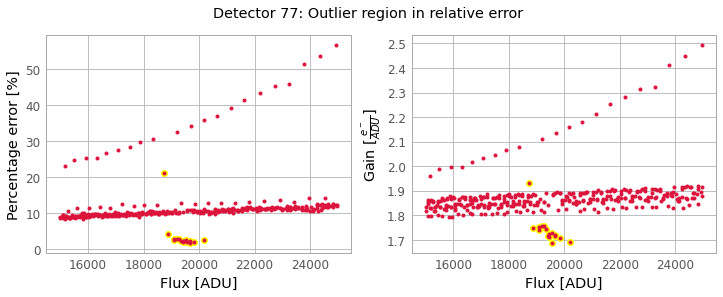

In [48]:
def outliers_relative_error(fluxx, gainn, gain_ptcc, CCD):
    """
    fluxx: flux from cpCovariances 
    gainn: gain from cpCovariances
    gain_ptcc: gain from Ptc
    CCD: detector number
    -------------------------------
    Return: indexes of outlier points
    """
    outlier_index = []    
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(f'Detector {CCD}: Outlier region in relative error ')
    for k in range(len(gainn[1,:])):
        relative = abs(gainn[:,k] - gain_ptcc[k])/gain_ptcc[k] * 100
        

        ########Outliers
        flux_outlier_index = np.where((fluxx[:,k]>15000) & (fluxx[:,k]<25000))[0]
        relative_outlier = relative[flux_outlier_index].min()
        relative_outlier_index = np.where(relative == relative_outlier)[0]
        outlier_index.append(relative_outlier_index[0])
        ##########
        axs[0].plot(fluxx[flux_outlier_index,k], relative[flux_outlier_index], '.', c='crimson', zorder=2)
        axs[0].plot(fluxx[relative_outlier_index,k], relative[relative_outlier_index], 'o', c='yellow', zorder=1)
        axs[1].plot(fluxx[relative_outlier_index,k], gainn[relative_outlier_index,k], 'o', c='yellow', zorder=1)
        axs[1].plot(fluxx[flux_outlier_index,k], gainn[flux_outlier_index, k], '.', c='crimson', zorder=2)
        
        for j in range(2):
            axs[j].set_xlabel('Flux [ADU]')
        axs[1].set_ylabel(r'Gain [$\frac{e^-}{ADU}$]')
        axs[0].set_ylabel('Percentage error [%]')
    return outlier_index

cp_outliers = outliers_relative_error(cp_flux55, cp_gain55, gain55, select_detector)
print(cp_outliers)

From the above figure and resulting indexes, for this particular CCD, the same flat contains all the outliers in each amplifier.

In [52]:
exposures55[157]

3021120700281